# Weather Data

In [2]:
# Suppress Warnings 
import warnings
warnings.filterwarnings('ignore')

# Import common GIS tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import rasterio.features
# import folium
import fsspec
import math

# Import Planetary Computer tools
import pystac
import pystac_client
import planetary_computer

In [28]:
xr.set_options(display_style="html")

## Load data

In [3]:
collection = pystac.read_file("https://planetarycomputer.microsoft.com/api/stac/v1/collections/terraclimate")
asset = collection.assets["zarr-https"]

In [4]:
store = fsspec.get_mapper(asset.href)
data = xr.open_zarr(store, **asset.extra_fields["xarray:open_kwargs"])


In [17]:
print(data)

<xarray.Dataset>
Dimensions:                 (time: 744, lat: 4320, lon: 8640, crs: 1)
Coordinates:
  * crs                     (crs) int16 3
  * lat                     (lat) float64 89.98 89.94 89.9 ... -89.94 -89.98
  * lon                     (lon) float64 -180.0 -179.9 -179.9 ... 179.9 180.0
  * time                    (time) datetime64[ns] 1958-01-01 ... 2019-12-01
Data variables: (12/18)
    aet                     (time, lat, lon) float32 dask.array<chunksize=(12, 1440, 1440), meta=np.ndarray>
    def                     (time, lat, lon) float32 dask.array<chunksize=(12, 1440, 1440), meta=np.ndarray>
    pdsi                    (time, lat, lon) float32 dask.array<chunksize=(12, 1440, 1440), meta=np.ndarray>
    pet                     (time, lat, lon) float32 dask.array<chunksize=(12, 1440, 1440), meta=np.ndarray>
    ppt                     (time, lat, lon) float32 dask.array<chunksize=(12, 1440, 1440), meta=np.ndarray>
    ppt_station_influence   (time, lat, lon) float32 dask

## Define test region: Greater Sydney, NSW, Australia

In [7]:
region_name = 'Greater Sydney, NSW'
min_lon, min_lat = (150.15, -34.25)  # Lower-left corner
max_lon, max_lat = (151.15, -33.25)  # Upper-right corner
bbox = (min_lon, min_lat, max_lon, max_lat)
latitude = (min_lat, max_lat)
longitude = (min_lon, max_lon)

In [11]:
clipped_data = data.sel(
    lon=slice(min_lon, max_lon), 
    lat=slice(max_lat, min_lat),
    time=slice('2015-01-01','2019-12-31'),
)

In [30]:
print(clipped_data)

<xarray.Dataset>
Dimensions:                 (time: 60, lat: 24, lon: 24, crs: 1)
Coordinates:
  * crs                     (crs) int16 3
  * lat                     (lat) float64 -33.27 -33.31 -33.35 ... -34.19 -34.23
  * lon                     (lon) float64 150.2 150.2 150.3 ... 151.1 151.1
  * time                    (time) datetime64[ns] 2015-01-01 ... 2019-12-01
Data variables: (12/18)
    aet                     (time, lat, lon) float32 dask.array<chunksize=(12, 24, 24), meta=np.ndarray>
    def                     (time, lat, lon) float32 dask.array<chunksize=(12, 24, 24), meta=np.ndarray>
    pdsi                    (time, lat, lon) float32 dask.array<chunksize=(12, 24, 24), meta=np.ndarray>
    pet                     (time, lat, lon) float32 dask.array<chunksize=(12, 24, 24), meta=np.ndarray>
    ppt                     (time, lat, lon) float32 dask.array<chunksize=(12, 24, 24), meta=np.ndarray>
    ppt_station_influence   (time, lat, lon) float32 dask.array<chunksize=(12, 24

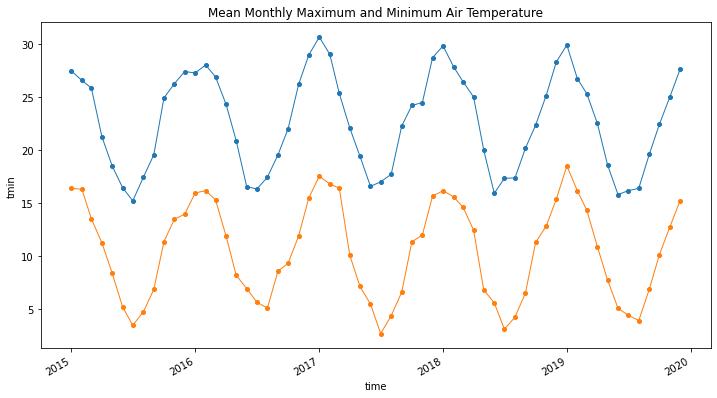

In [13]:
fig = plt.figure(figsize=(12, 6))
clipped_data["tmax"].mean(dim=["lat","lon"]).plot(marker='o',markersize=4,linewidth=1)
clipped_data["tmin"].mean(dim=["lat","lon"]).plot(marker='o',markersize=4,linewidth=1)
plt.title("Mean Monthly Maximum and Minimum Air Temperature")
plt.show()

In [15]:
print(clipped_data["tmax"].mean(dim=["lat","lon"]))

<xarray.DataArray 'tmax' (time: 60)>
dask.array<mean_agg-aggregate, shape=(60,), dtype=float32, chunksize=(12,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2015-01-01 2015-02-01 ... 2019-12-01


In [50]:
len(clipped_data.keys())

18

In [65]:
for key, name in zip(data.keys(), [data.variables[key].attrs['long_name'] for key in data.keys()]):
    print(key, name)

aet water_evaporation_amount
def water_potential_evaporation_amount_minus_water_evaporation_amount
pdsi palmer_drought_severity_index
pet water_potential_evaporation_amount
ppt precipitation_amount
ppt_station_influence station_influence
q runoff_amount
soil soil_moisture_content
srad downwelling_shortwave_flux_in_air
swe liquid_water_content_of_surface_snow
tmax air_temperature
tmax_station_influence station_influence
tmin air_temperature
tmin_station_influence station_influence
vap water_vapor_partial_pressure_in_air
vap_station_influence station_influence
vpd vapor_pressure_deficit
ws wind_speed


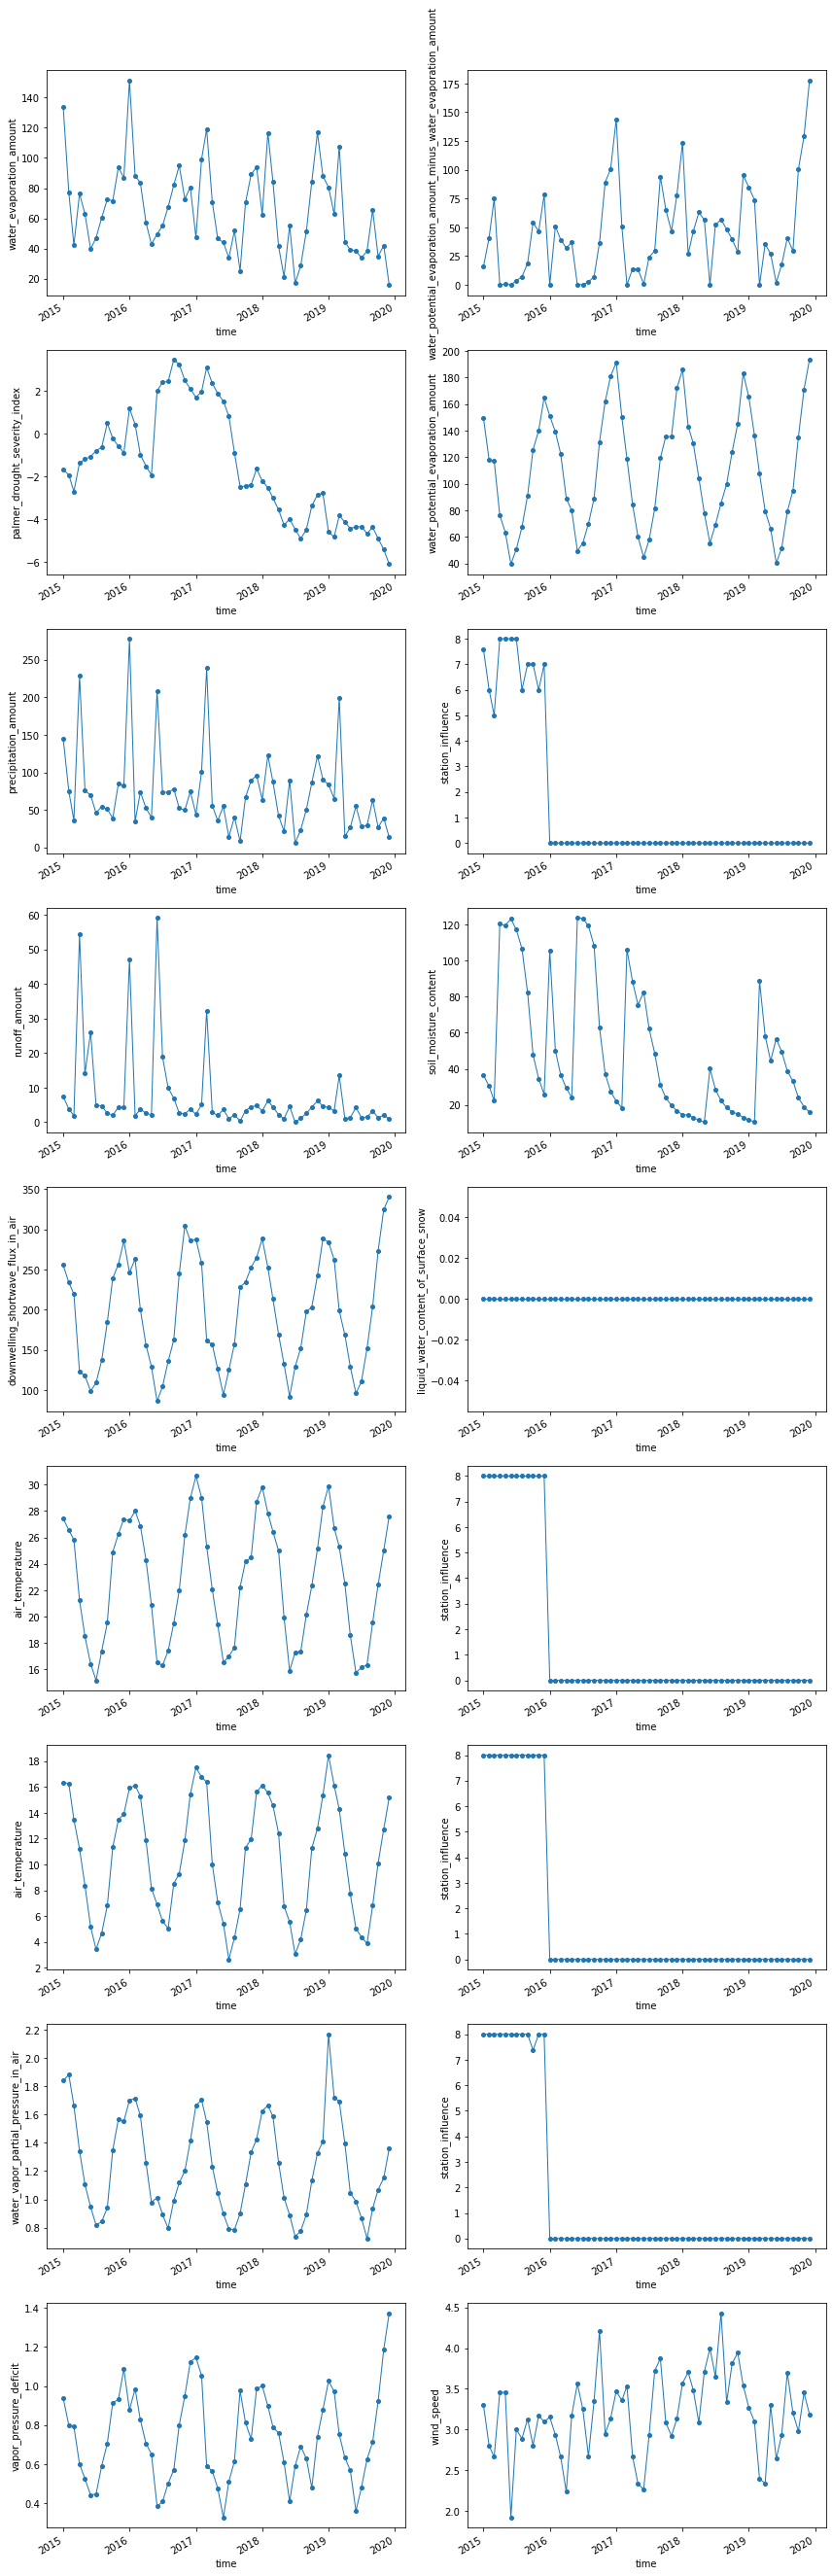

In [73]:
fig, axs = plt.subplots(nrows=9, ncols=2, figsize=(12, 36))
for i, key in enumerate(list(clipped_data.keys())):
    ax = axs[int(i / 2), i % 2]
    clipped_data[key].mean(dim=["lat","lon"]).plot(ax=ax, marker='o',markersize=4,linewidth=1)
    ax.set_ylabel(ylabel=clipped_data.variables[key].attrs['long_name'])
    
fig.tight_layout()

In [130]:
def is_ond(month):
    return (month >= 10) & (month <= 12)

clipped_data_ond = clipped_data.sel(time=is_ond(clipped_data['time.month']))

In [132]:
print(clipped_data_ond)

<xarray.Dataset>
Dimensions:                 (time: 15, lat: 24, lon: 24, crs: 1)
Coordinates:
  * crs                     (crs) int16 3
  * lat                     (lat) float64 -33.27 -33.31 -33.35 ... -34.19 -34.23
  * lon                     (lon) float64 150.2 150.2 150.3 ... 151.1 151.1
  * time                    (time) datetime64[ns] 2015-10-01 ... 2019-12-01
Data variables: (12/18)
    aet                     (time, lat, lon) float32 dask.array<chunksize=(3, 24, 24), meta=np.ndarray>
    def                     (time, lat, lon) float32 dask.array<chunksize=(3, 24, 24), meta=np.ndarray>
    pdsi                    (time, lat, lon) float32 dask.array<chunksize=(3, 24, 24), meta=np.ndarray>
    pet                     (time, lat, lon) float32 dask.array<chunksize=(3, 24, 24), meta=np.ndarray>
    ppt                     (time, lat, lon) float32 dask.array<chunksize=(3, 24, 24), meta=np.ndarray>
    ppt_station_influence   (time, lat, lon) float32 dask.array<chunksize=(3, 24, 24),